In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
cd 'drive/MyDrive/Colab Notebooks/NewsClassification'

/content/drive/MyDrive/Colab Notebooks/NewsClassification


In [ ]:
import os
import re
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing.text import one_hot

In [ ]:
def read_json(path):
    file_contents = list()
    f = open(path)
    data = json.load(f)
    for i in range(500):
            file_contents.append(data["Content"][str(i)])
    
    return file_contents
def read_files(path):
    file_contents = list()
    filenames = os.listdir(path)
    
    for i in range(len(filenames)):
        with open(path+filenames[i],errors='ignore') as f:
            file_contents.append(f.read())
    
    return file_contents

In [ ]:
class_0 = read_json("army.json")
class_1 = read_json("business.json")
class_2 = read_json("politics.json")
class_3 = read_files('tech/')
class_4 = read_files('sport/')

In [ ]:
print(len(class_0))
print(len(class_1))
print(len(class_2))
print(len(class_3))
print(len(class_4))

500
500
500
401
511


In [ ]:
all_texts = np.append(class_0, class_1)
all_texts = np.append(all_texts, class_2)
all_texts = np.append(all_texts, class_3)
all_texts = np.append(all_texts, class_4)


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
def clean(text):
    # Lowering letters
    text = text.lower()
    # Removing html tags
    text = re.sub('<[^>]*>', '', text)
    # Removing emails
    text = re.sub('\S*@\S*\s?', '', text)
    # Removing urls
    text = re.sub('https?://[A-Za-z0-9]','',text)
    # Removing numbers
    text = re.sub('[^a-zA-Z]',' ',text)
    word_tokens = word_tokenize(text)    
    filtered_sentence = []
    for word_token in word_tokens:
        if word_token not in stop_words:
            filtered_sentence.append(word_token)
    
    # Joining words
    text = (' '.join(filtered_sentence))
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


NameError: ignored

In [ ]:
all_cleaned_texts = np.array([clean(text) for text in all_texts])

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cleaned_texts)

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
num_words = len(tokenizer.word_index)
print(num_words)

32447


In [ ]:
max_len = 300

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
all_cleaned_sequences = tokenizer.texts_to_sequences(all_cleaned_texts)
all_cleaned_padded = pad_sequences(
    all_cleaned_sequences, maxlen=max_len, padding="pre", truncating="post"
)

In [ ]:
all_cleaned_padded

array([[    0,     0,     0, ...,    86,   840,   405],
       [    0,     0,     0, ...,    11,  2729,   904],
       [    0,     0,     0, ...,   109,  5802, 14224],
       ...,
       [    0,     0,     0, ...,  1307,  2380,  1424],
       [    0,     0,     0, ...,  1100,  2043,    56],
       [  205,  2419,    25, ...,    18, 18114,  3815]], dtype=int32)

In [ ]:
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))

Number of unique words: 32447


In [ ]:
embedding_dict = {}
f = open(r'glove.840B.300d.txt', encoding="utf8", mode="r")
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embedding_dict[word] = coefs
f.close()

In [ ]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

for word, i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

In [ ]:
labels_0 = np.array([0] * len(class_0))
labels_1 = np.array([1] * len(class_1))
labels_2 = np.array([2] * len(class_2))
labels_3 = np.array([3] * len(class_3))
labels_4 = np.array([4] * len(class_4))

In [ ]:
all_labels = np.append(labels_0, labels_1)
all_labels = np.append(all_labels, labels_2)
all_labels = np.append(all_labels, labels_3)
all_labels = np.append(all_labels, labels_4)

In [ ]:
all_labels = all_labels[:, np.newaxis]
one_hot_encoder = OneHotEncoder(sparse=False)
all_labels = one_hot_encoder.fit_transform(all_labels)

In [ ]:
import pickle
with open("encoder", "wb") as f: 
    pickle.dump(one_hot_encoder, f)

In [ ]:
print(all_labels[0])

[1. 0. 0. 0. 0.]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_cleaned_padded, all_labels, test_size=0.1, random_state=11)

In [ ]:
from keras.layers import *
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.regularizers import l1_l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import load_model
from keras import regularizers
from keras.utils.vis_utils import plot_model
from keras import backend as K

In [ ]:
def repeat(x):
  return K.repeat_elements(x, rep=100, axis=-1)
def sum_along_axis(x):
  return K.sum(x, axis=1)
inp = Input(shape=(max_len,))
embed = Embedding(input_dim=num_words, output_dim=300, weights=[embedding_matrix], input_length=max_len,trainable=True)(inp)
  # if rnn == 'gru':
  #   lstm = GRU(hidden_dim, return_sequences=True, dropout=0.2)(embed)
  # else:  
lstm = LSTM(100, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(embed)
wis = TimeDistributed(Dense(1, activation='sigmoid'))(lstm)
wis = Lambda(repeat)(wis)
wd = Multiply()([lstm, wis])
wd = Lambda(sum_along_axis)(wd)
d = Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01))(wd)
d = Dropout(0.2)(d)
out = Dense(5, activation='softmax')(d)
model_wrnn = Model(inputs = inp, outputs = out)
print(model_wrnn.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     9734400     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 300, 100)     160400      embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 300, 1)       101         lstm_1[0][0]                     
____________________________________________________________________________________________

In [ ]:
model_wrnn.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01),metrics=['categorical_accuracy'])

In [ ]:
train = model_wrnn.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/20
17/17 [==============================] - 28s 1s/step - loss: 14.5645 - categorical_accuracy: 0.4378 - val_loss: 1.6233 - val_categorical_accuracy: 0.8760
Epoch 2/20
17/17 [==============================] - 21s 1s/step - loss: 1.3470 - categorical_accuracy: 0.9231 - val_loss: 1.2627 - val_categorical_accuracy: 0.9339
Epoch 3/20
17/17 [==============================] - 21s 1s/step - loss: 1.0934 - categorical_accuracy: 0.9766 - val_loss: 1.1042 - val_categorical_accuracy: 0.9752
Epoch 4/20
17/17 [==============================] - 21s 1s/step - loss: 0.9785 - categorical_accuracy: 0.9931 - val_loss: 1.0435 - val_categorical_accuracy: 0.9752
Epoch 5/20
17/17 [==============================] - 21s 1s/step - loss: 0.8984 - categorical_accuracy: 0.9923 - val_loss: 0.9747 - val_categorical_accuracy: 0.9752
Epoch 6/20
17/17 [==============================] - 22s 1s/step - loss: 0.8063 - categorical_accuracy: 0.9982 - val_loss: 0.8979 - val_categorical_accuracy: 0.9752
Epoch 7/20
17/1

In [ ]:
predictions = model_wrnn.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)

In [ ]:
y_test_evaluate = np.argmax(y_test, axis=1)

In [ ]:
cm = confusion_matrix(y_test_evaluate, predictions)

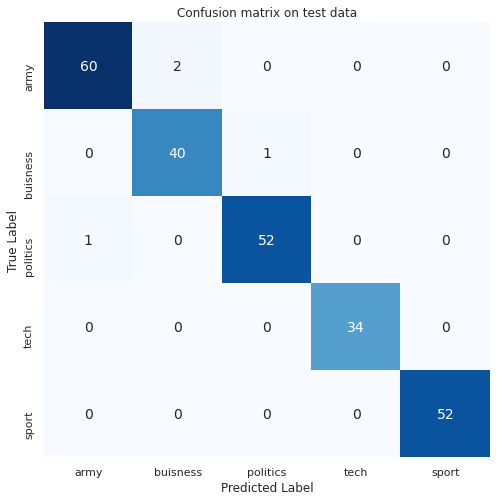

In [ ]:
labels = ['army', 'buisness', 'politics', 'tech','sport']
plt.figure(figsize=(8,8))
plt.title('Confusion matrix on test data')
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, 
            cmap=plt.cm.Blues, cbar=False, annot_kws={'size':14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
model_wrnn.save('news_text_classification.h5')

In [ ]:
from keras.models import load_model
model = load_model('news_text_classification.h5')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     9734400     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 300, 100)     160400      embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 300, 1)       101         lstm_1[0][0]                     
____________________________________________________________________________________________

In [ ]:
model_json = model.to_json()
with open("classifier.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("classifier.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json
json_file = open('classifier.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("classifier.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
X_test.shape

(242, 300)

In [ ]:
test = X_test[0].reshape(1,300)
predictions = model_wrnn.predict(test)
predictions = one_hot_encoder.inverse_transform(predictions)
predictions

array([[0]])

In [ ]:
%ls

 army.json                                      NewsClassification2.ipynb
 business.json                                  NewsClassification4.ipynb
 c.csv                                          NewsClassification.ipynb
 comp.graphics/                                 news_text_classification.h5
'Copy of WRNN-News_Text_Classification.ipynb'   politics.json
 general.json                                   rec.motorcycles/
 glove300d.pkl                                  sci.med/
 glove.840B.300d.txt                            SGPfinalModel.ipynb
 glove.840B.300d.zip                            sport/
 glove.txt                                      talk.politics.misc/
 NewsClassificatio3.ipynb                       tech/
'NewsClassification (1).ipynb'


In [ ]:
import pandas as pd

scrapped = pd.read_csv('c.csv')

scrapped.shape

(52, 6)

In [ ]:
scrapped_text = []
for ind in scrapped.index:
     scrapped_text.append(scrapped['newstitle'][ind]+scrapped['content'][ind])

TypeError: ignored

In [ ]:
scrapped_text

['Three from Tamil Nadu killed in Kannur road accidentThe victims hailed from Tenkasi in Tamil Nadu. The bodies were kept at the district hospital here, police said. ',
 'CRPF jawan killed in accident in GhazipurJawan Alok Kumar Singh was seriously injured in the accident that took place on Sunday and was rushed to hospital, where he died during treatment ',
 'West Bengal: Locals torch trucks in Gurguripal after biker’s death in accidentPolice rushed to spot immediately after learning of the incident.',
 'NDTV case: CBI told to file reportAfter the petition was filed on Thursday, Justice Vinod Goel posted the matter for hearing on September 21.',
 "Tension in UP village after Hindu Yuva Vahini activist’s deathPolice said an FIR was registered against unidentified persons and the victim's body sent for post mortem",
 "Covid surge spreads to 28 of Maharashtra's 36 districtsCovid-19 cases have spread to more districts in the state over the past week. Active cases in 28 of the 36 districts

In [ ]:
all_cleaned_texts = np.array([clean(text) for text in scrapped_text])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
all_cleaned_sequences = tokenizer.texts_to_sequences(all_cleaned_texts)
all_cleaned_padded = pad_sequences(
    all_cleaned_sequences, maxlen=max_len, padding="pre", truncating="post"
)

In [ ]:
all_cleaned_padded.shape

(27, 300)

In [ ]:
predictions = new_model.predict(all_cleaned_padded)
predictions = one_hot_encoder.inverse_transform(predictions)

In [ ]:
for i in range(27):
  print(predictions[i],scrapped_text[i])

[2] Three from Tamil Nadu killed in Kannur road accidentThe victims hailed from Tenkasi in Tamil Nadu. The bodies were kept at the district hospital here, police said. 
[2] CRPF jawan killed in accident in GhazipurJawan Alok Kumar Singh was seriously injured in the accident that took place on Sunday and was rushed to hospital, where he died during treatment 
[4] West Bengal: Locals torch trucks in Gurguripal after biker’s death in accidentPolice rushed to spot immediately after learning of the incident.
[2] NDTV case: CBI told to file reportAfter the petition was filed on Thursday, Justice Vinod Goel posted the matter for hearing on September 21.
[2] Tension in UP village after Hindu Yuva Vahini activist’s deathPolice said an FIR was registered against unidentified persons and the victim's body sent for post mortem
[2] Covid surge spreads to 28 of Maharashtra's 36 districtsCovid-19 cases have spread to more districts in the state over the past week. Active cases in 28 of the 36 distric

In [ ]:
!pip install celery

     |████████████████████████████████| 399kB 2.8MB/s 
     |████████████████████████████████| 92kB 6.6MB/s 
     |████████████████████████████████| 184kB 12.4MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
  Created wheel for click-didyoumean: filename=click_didyoumean-0.0.3-cp37-none-any.whl size=2147 sha256=dcd49cd8b17d34a42c851ace8eb65d15fccf3bcb7c6bc0d15a4660c77639ea8d
  Stored in directory: /root/.cache/pip/wheels/6e/b6/7e/f5861c2196073138d49bbe662671e6a983236ea10db6ad9836
Successfully built click-didyoumean


In [ ]:
from time import sleep
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import requests
from keras.models import load_model
new_model = load_model('news_text_classification.h5')

@shared_task
# do some heavy stuff let scrap some newshit
def crawl_news():
    print('Crawling news and creating objects in database ..')
    page = requests.get('https://www.india.com/news/india/')
    
    bs = BeautifulSoup(page.text, "html.parser")
    #print(bs)
    # Find first 5 table rows
    articles = bs.find("ul",class_="catPgList")
    headlines = articles.find_all('li',class_="catPgListitem")[0:5]
    #print(headlines)

    for headline in headlines:
        box = headline.find('figcaption')
        #print(box)
        newstitle = box.find('h3').text
        category =box.find('a').attrs['href']

        partipage = requests.get(category)
        bs = BeautifulSoup(partipage.text, "html.parser")
        newpage = bs.find('article',class_="common-text")
        content = newpage.find('p').text.strip()
       
    sleep(3)

@shared_task
def crawl_news_express():
    print('Crawling data and creating objects in database ..')
    page = requests.get('https://timesofindia.indiatimes.com/briefs')
    
    bs = BeautifulSoup(page.text, "html.parser")
    #print(bs)
    # Find first 5 table rows
    articles = bs.find("div",class_="briefs_outer clearfix")
    headlines = articles.find_all('div',class_="brief_box")[0:4]
    headlines2 = articles.find_all('div',class_="brief_box")[5:9]
    #print(headlines)

    for headline in headlines:
        
        newstitle = headline.find('h2').find('a').contents[0]
        content = headline.find('p').find('a').contents[0]
        category ='https://timesofindia.indiatimes.com/'+headline.find('h2').find('a').attrs['href']
        print(newstitle,content,category)
        Newsapi.objects.get_or_create(
            newstitle = str(newstitle),
            content = str(content),
            source = "Times of India",
            category= category
        )
    for headline in headlines2:
        
        newstitle = headline.find('h2').find('a').contents[0]
        content = headline.find('p').find('a').contents[0]
        category ='https://timesofindia.indiatimes.com/'+headline.find('h2').find('a').attrs['href']

        print(newstitle,content,category)
        Newsapi.objects.get_or_create(
            newstitle = str(newstitle),
            content = str(content),
            source = "Times of India",
            category= category
        )
    sleep(3)



OSError: ignored

In [ ]:
def crawl_news(url):
    print('Crawling news and creating objects in database ..')
    page = requests.get(url)
    
    bs = BeautifulSoup(page.text, "html.parser")
    #print(bs)
    # Find first 5 table rows
    articles = bs.find("ul",class_="catPgList")
    headlines = articles.find_all('li',class_="catPgListitem")[0:5]
    #print(headlines)
    scrapped_articles = []
    for headline in headlines:
        box = headline.find('figcaption')
        #print(box)
        newstitle = box.find('h3').text
        category =box.find('a').attrs['href']
          
        partipage = requests.get(category)
        bs = BeautifulSoup(partipage.text, "html.parser")
        newpage = bs.find('article',class_="common-text")
        content = newpage.find('p').text.strip()
        scrapped_articles.append(newstitle+content)
    return scrapped_articles
    


In [ ]:
crawl_news('https://www.india.com/news/india/')


Crawling news and creating objects in database ..


['West Bengal Assembly Election 2021: 78.36% Voter Turnout Recorded Till 5:45 PM | HighlightsWest Bengal Assembly Election 2021 Updates: Amid tight security and high-voltage campaigning, the fifth phase of polling in West Bengal for votes in 45 assembly seats in six districts – North 24 Parganas, Purba Bardhaman, Nadia, Jalpaiguri, Darjeeling and Kalimpong – was held today. A total of 319 candidates – of which 39 are women – are set to battle as more than half of the total 294 seats in Bengal is sealed by end of the day. A key phase for both, Trinamool Congress and the BJP, several key ministers including TMC’s Gautam Deb, Bratya Basu, BJP’s Jagannath Sarkar and Samik Bhattacharya are contesting in today’s constituencies. Polling in West Bengal is being conducted in eight phases, of which, 4 phases with 135 seats have already been completed. Counting of votes and results to the 294 Vidhan Sabha seats and 126-member Assam Legislative Assembly in West Bengal will be declared on May 2, 20

In [ ]:
import pickle
scrapped_articles = crawl_news('https://timesofindia.indiatimes.com/briefs').extend(crawl_news('https://www.india.com/news/india/'))
all_cleaned_texts = np.array([clean(text) for text in scrapped_articles])
    
from tensorflow.keras.preprocessing.sequence import pad_sequences
with open('tokenizer.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)
    
all_cleaned_sequences = tokenizer.texts_to_sequences(all_cleaned_texts)
all_cleaned_padded = pad_sequences(all_cleaned_sequences, maxlen=300, padding="pre", truncating="post")
    
predictions = new_model.predict(all_cleaned_padded)
    
with open('encoder', 'rb') as handle:
  one_hot_encoder = pickle.load(handle)
predictions = one_hot_encoder.inverse_transform(predictions)

Crawling news and creating objects in database ..


In [ ]:
labels = ['army', 'buisness', 'politics', 'tech','sport']
for i in predictions:
  print(labels[i[0]])
for i in scrapped_articles:
  print(i)

politics
politics
politics
tech
politics
Haridwar Kumbh Mela 2021: Will Mela be Cut Short Due to Covid? Read What Official SaysHaridwar: At a time when Haridwar is witnessing a massive surge in its Coronavirus caseload, the Uttarakhand health secretary has pleaded before the High Court to ease the 50,000 RT-PCR Covid test limit per day in the city. Notably, this comes amid the ongoing Kumbh Mela in the city. The High Court had on March 31 directed the authorities in Haridwar to conduct 50,000 tests per day. Also Read - Kumbh Mela: Thousands of Devotees Take Dip Into Ganga For Shahi Snan Flouting COVID Norms
UP Issues Quarantine Guidelines For Migrant Workers Returning to State | Coronavirus LIVE UpdatesNew Delhi: In highest single-day spike in Coronavirus infections, Delhi yesterday logged 17,000 fresh cases, almost double the 9925 Covid cases registered in Mumbai. Further, a total of 104 people succumbed to the disease within 24 hours in Delhi– the highest in three months. Delhi Chief

In [ ]:
scrapped_articles = crawl_news('https://www.india.com/news/india/')

Crawling news and creating objects in database ..


In [ ]:
scrapped_articles

['West Bengal Assembly Election 2021: 78.36% Voter Turnout Recorded Till 5:45 PM | HighlightsWest Bengal Assembly Election 2021 Updates: Amid tight security and high-voltage campaigning, the fifth phase of polling in West Bengal for votes in 45 assembly seats in six districts – North 24 Parganas, Purba Bardhaman, Nadia, Jalpaiguri, Darjeeling and Kalimpong – was held today. A total of 319 candidates – of which 39 are women – are set to battle as more than half of the total 294 seats in Bengal is sealed by end of the day. A key phase for both, Trinamool Congress and the BJP, several key ministers including TMC’s Gautam Deb, Bratya Basu, BJP’s Jagannath Sarkar and Samik Bhattacharya are contesting in today’s constituencies. Polling in West Bengal is being conducted in eight phases, of which, 4 phases with 135 seats have already been completed. Counting of votes and results to the 294 Vidhan Sabha seats and 126-member Assam Legislative Assembly in West Bengal will be declared on May 2, 20

In [ ]:
url = 'http://b30f9477e0e8.ngrok.io/predict?scrapped_news={}'.format(scrapped_articles)
print(url)
predictions = requests.post('http://b30f9477e0e8.ngrok.io/predict?scrapped_news={}'.format(scrapped_articles))


http://b30f9477e0e8.ngrok.io/predict?scrapped_news=['West Bengal Assembly Election 2021: 78.36% Voter Turnout Recorded Till 5:45 PM | HighlightsWest Bengal Assembly Election 2021 Updates: Amid tight security and high-voltage campaigning, the fifth phase of polling in West Bengal for votes in 45 assembly seats in six districts – North 24 Parganas, Purba Bardhaman, Nadia, Jalpaiguri, Darjeeling and Kalimpong – was held today. A total of 319 candidates – of which 39 are women – are set to battle as more than half of the total 294 seats in Bengal is sealed by end of the day. A key phase for both, Trinamool Congress and the BJP, several key ministers including TMC’s Gautam Deb, Bratya Basu, BJP’s Jagannath Sarkar and Samik Bhattacharya are contesting in today’s constituencies. Polling in West Bengal is being conducted in eight phases, of which, 4 phases with 135 seats have already been completed. Counting of votes and results to the 294 Vidhan Sabha seats and 126-member Assam Legislative As

In [ ]:
predictions


<Response [404]>